# Tutorial 5b: Resampling methods

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This document was generated from a Jupyter notebook.  You can download the notebook [here](t5b_resampling_methods.ipynb).*

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import numba

import bebi103

import altair as alt

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

In the [last tutorial](t5a_generative_models_and_rng.html), we learned about generative models and using random number generation to create data sets drawn from a generative model. In [lecture 4](../lecture_notes/l04_frequentist_methods.pdf), we discussed the **plug-in principle**, in which we approximate the distribution function of the generative model, $F$, with the **empirical distribution function**, $\hat{F}$. We then approximate call of our statistical functional of $F$ using $\hat{F}$; $T(F)\approx T(\hat{F})$. Using the frequentist perspective we talked about using the plug-in principle and **bootstrapping** to compute confidence intervals and do hypothesis testing. In this tutorial, we will go over how we implement this in practice. We will work with some real data on the reproductive health of male bees that have been treated with pesticide.

It is important as you go through this tutorial to remember that you do not know what the generative distribution is. We are only approximating it using the plug-in principle. Since we do not know what $F$ is, we do not know what its parameters are, so we therefore cannot estimate them. Rather, we can study **summary statistics**, such as means, variances, or even the ECDF itself, and how they may vary from experiment to experiment. In this sense, we are doing **nonparametric inference**. We do not have a parametrized model in mind, but are investigating how experimental results might vary upon repetition of the experiment.

## The data set

Neonicotinoid pesticides are thought to have inadvertent effects on service-providing insects such as bees. A recent study of this was recently [featured in the New York Times](http://www.nytimes.com/2016/07/29/science/neonicotinoid-insecticide-bee-sperm.html). The original paper is [Straub, et al.,  Proc. Royal Soc. B 283(1835): 20160506](http://dx.doi.org/10.1098/rspb.2016.0506). Straub and coworkers put their [data in the Dryad repository](http://dx.doi.org/10.5061/dryad.bs515), which means that it is free to all to work with!

(Do you see a trend here? If you want people to think deeply about your results, explore them, learn from them, in general further science with them, *make your data publicly available.* Strongly encourage the members of your lab to do the same.)

We will look at the sperm quality of drone bees using [this data set](../data/bee_sperm.csv). First, let's load in the data set and check it out.

In [2]:
df = pd.read_csv('../data/bee_sperm.csv', comment='#')
df.head()

Specimen Treatment Environment  TreatmentNCSS Sample ID  Colony  Cage  \
0       227   Control        Cage              1    C2-1-1       2     1   
1       228   Control        Cage              1    C2-1-2       2     1   
2       229   Control        Cage              1    C2-1-3       2     1   
3       230   Control        Cage              1    C2-1-4       2     1   
4       231   Control        Cage              1    C2-1-5       2     1   

   Sample  Sperm Volume per 500 ul  Quantity  ViabilityRaw (%)    Quality  \
0       1                  2150000   2150000  96.7263814616756  96.726381   
1       2                  2287500   2287500  96.3498079760595  96.349808   
2       3                    87500     87500             98.75  98.750000   
3       4                  1875000   1875000  93.2874208336941  93.287421   
4       5                  1587500   1587500  97.7925061050061  97.792506   

   Age (d)  Infertil  AliveSperm  Quantity Millions  Alive Sperm Millions  \
0       14         0     2079617             2.1500              2.079617   
1       14         0     2204001             2.2875              2.204001   
2       14         0       86406             0.0875              0.086406   
3       14         0     1749139             1.8750              1.749139   
4       14         0     1552456             1.5875              1.552456   

   Dead Sperm Millions  
0             0.070383  
1             0.083499  
2             0.001094  
3             0.125861  
4             0.035044

We are interested in the **number of alive sperm** in the samples. Let's first explore the data by making ECDFs for the two groups we will compare, those treated with pesticide ("Pesticide") and those that are not ("Control").

In [3]:
p = bebi103.viz.ecdf_collection(df, cats=['Treatment'], val='Alive Sperm Millions')
bokeh.io.show(p)

The visual inspection of the ECDFs suggests that indeed the control drones have more alive sperm than those treated with pesticide. But how variable would these ECDFs be if we repeated the experiment?

## Bootstrap samples and ECDFs

To address this question, we can generate bootstrap samples from the experimental data and make lots of ECDFs. We can then plot them all to see how the ECDF might vary. Recall that a bootstrap sample from a data set of $n$ repeated measurements is generated by drawing $n$ data points out of the original data set with replacement. The `np.random.choice()` function allows for randomly drawing elements out of an array. Let's generate 100 bootstrap samples and plot their ECDFs to visualize how our data set might change as we repeat the experiment.

In [4]:
# Set up Numpy arrays for convenience (also much better performance)
alive_ctrl = df.loc[df['Treatment']=='Control', 'Alive Sperm Millions'].values
alive_pest = df.loc[df['Treatment']=='Pesticide', 'Alive Sperm Millions'].values

# Make 100 bootstrap samples
for _ in range(100):
    p = bebi103.viz.ecdf(np.random.choice(alive_ctrl, size=len(alive_ctrl)), 
                         p=p, alpha=0.02, color='#4e79a7')
    p = bebi103.viz.ecdf(np.random.choice(alive_pest, size=len(alive_pest)), 
                         p=p, alpha=0.02, color='#f28e2b')

bokeh.io.show(p)

From this graphical display, we can already see that the ECDFs do not overlap in 100 bootstrap samples, so there is likely a real difference between the two treatments.

## Speeding up sampling with Numba

We can make sampling faster by employing **just-in-time compilation**, wherein the Python code is compiled at runtime into machine code. This results in a substantial speed boost. [Numba](http://numba.pydata.org) is a powerful tool for this purpose, and we will use it. Bear in mind, though, that not all Python code is Numba-able. 

In [5]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

Let's quickly quantify the speed boost.

In [6]:
%timeit np.random.choice(alive_ctrl, size=len(alive_ctrl))
%timeit draw_bs_sample(alive_ctrl)

13.5 µs ± 266 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
The slowest run took 5.19 times longer than the fastest. This could mean that an intermediate result is being cached.
4.81 µs ± 3.59 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's a factor of 6 or so increase. That can make a big difference when generating lots of bootstrap samples.

## Bootstrap replicates and confidence intervals

We have plotted the ECDF of the data, which is instructive, but we would like to get estimates for properties of the ECDF. Remember, when doing nonparametric plug-in estimates, we plug in the ECDF for the CDF. We do not need to specify what the distribution (described mathematically by the CDF, or equivalently by the PDF) is, just that we approximate it by the empirical distribution.

In lecture, we laid out the procedure to compute a confidence interval.

1. Generate $B$ independent bootstrap samples.
2. Compute the statistic of interest for each bootstrap sample to get the **bootstrap replicates**.
3. The $100(1-\alpha)$ percent confidence interval consists of the percentiles $100\alpha/2$ and $100(1 - \alpha/2)$ of the bootstrap replicates.

A key step here is computing the bootstrap replicate. We will write a couple functions for this. The first is generic; it takes as an argument the function to be used to compute the statistic of interest (e.g., `np.mean` or `np.median`). We will also write a few functions for commonly computed statistics, which enables us to use Numba to greatly speed up the process of generating bootstrap replicates.

In [7]:
def draw_bs_reps(data, stat_fun, size=1):
    """
    Draw boostrap replicates computed with stat_fun from 1D data set.
    """
    return np.array([stat_fun(draw_bs_sample(data)) for _ in range(size)])


@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=1):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out


@numba.jit(nopython=True)
def draw_bs_reps_median(data, size=1):
    """
    Draw boostrap replicates of the median from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.median(draw_bs_sample(data))
    return out


@numba.jit(nopython=True)
def draw_bs_reps_std(data, size=1):
    """
    Draw boostrap replicates of the standard deviation from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.std(draw_bs_sample(data))
    return out

Now, let's get bootstrap replicates for the mean of each of the two treatments.

In [8]:
bs_reps_mean_ctrl = draw_bs_reps_mean(alive_ctrl, size=10000)
bs_reps_mean_pest = draw_bs_reps_mean(alive_pest, size=10000)

We can now compute the confidence intervals by computing the percentiles using the `np.percentile()` function.

In [9]:
# 95% confidence intervals
mean_ctrl_conf_int = np.percentile(bs_reps_mean_ctrl, [2.5, 97.5])
mean_pest_conf_int = np.percentile(bs_reps_mean_pest, [2.5, 97.5])

print("""
Mean alive sperm count 95% conf int control (millions):   [{0:.2f}, {1:.2f}]
Mean alive sperm count 95% conf int treatment (millions): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_ctrl_conf_int) + tuple(mean_pest_conf_int))))


Mean alive sperm count 95% conf int control (millions):   [1.68, 2.08]
Mean alive sperm count 95% conf int treatment (millions): [1.11, 1.49]



We can also use the bootstrap replicates to plot the probability distribution of mean alive sperm count. *Remember*: This is not a confidence interval on a parameter value. That does not make sense on frequentist statistics. It is the confidence interval describing what we would get as a plug-in estimate for the mean if we did the experiment over and over again.

In [10]:
p = bebi103.viz.ecdf(bs_reps_mean_ctrl,
                     x_axis_label='alive sperm (millions)',
                     color='#4e79a7',
                     legend='control')
p = bebi103.viz.ecdf(bs_reps_mean_pest, color='#f28e2b', legend='pesticide', p=p)

p.legend.location = 'bottom_right'

bokeh.io.show(p)

These are both nice, Gaussian distributions with just a little bit of overlap in the tails. This is expected, the mean alive sperm count should be Gaussian distributed as per the central limit theorem.

We can do the same procedure for other statistical quantities that do not follow the central limit theorem. The procedure is exactly the same. We will do it for the median.

In [11]:
# Get the bootstrap replicates
bs_reps_median_ctrl = draw_bs_reps_median(alive_ctrl, size=10000)
bs_reps_median_pest = draw_bs_reps_median(alive_pest, size=10000)

# 95% confidence intervals
median_ctrl_conf_int = np.percentile(bs_reps_median_ctrl, [2.5, 97.5])
median_pest_conf_int = np.percentile(bs_reps_median_pest, [2.5, 97.5])

print("""
Median alive sperm count 95% conf int control (millions):   [{0:.2f}, {1:.2f}]
Median alive sperm count 95% conf int treatment (millions): [{2:.2f}, {3:.2f}]
""".format(*(tuple(median_ctrl_conf_int) + tuple(median_pest_conf_int))))

# Get ECDF points from bootstrap replicates
p = bebi103.viz.ecdf(bs_reps_median_ctrl,
                     x_axis_label='alive sperm (millions)',
                     color='#4e79a7',
                     legend='control')
p = bebi103.viz.ecdf(bs_reps_median_pest, color='#f28e2b', legend='pesticide', p=p)
p.legend.location = 'bottom_right'
bokeh.io.show(p)


Median alive sperm count 95% conf int control (millions):   [1.63, 2.11]
Median alive sperm count 95% conf int treatment (millions): [0.96, 1.50]



The results are similar, and we clearly see nonGaussianity in the ECDFs.

## Pairs bootstrap and correlation

We might wish to investigate how two measured quantities are correlated. For example, if the number of dead sperm and the number of alive sperm are closely correlated, this would mean that a given drone produces some quantity of sperm and some fraction tend to be dead. Let's take a look at this.

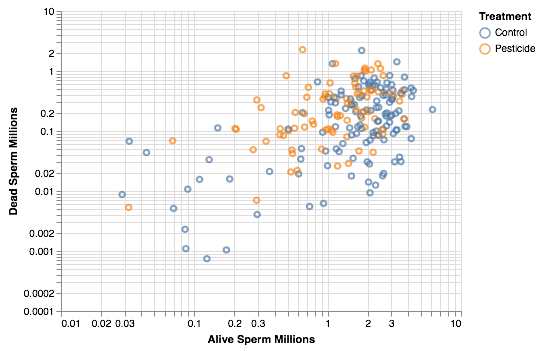

In [12]:
# Only use values greater than zero for log scale
inds = (df['Alive Sperm Millions'] > 0) & (df['Dead Sperm Millions'] > 0)

alt.Chart(df.loc[inds, :]
    ).mark_point(
    ).encode(
        x=alt.X('Alive Sperm Millions:Q', scale=alt.Scale(type='log')),
        y=alt.Y('Dead Sperm Millions:Q', scale=alt.Scale(type='log')),
        color='Treatment:N'
    )

There seems to be some correlation (on a log scale), but it is difficult to tell. We can compute the correlation with the **Pearson correlation coefficient**. This is the a measure of the covariance between variables (in this case alive and dead sperm) divided by the geometric mean of the individual variances and is implemented with `np.corrcoef()`, but we will code our own.

How can we get a confidence interval on a correlation coefficient? We can again apply the bootstrap, but this time, the replicate is a *pair* of data, in this case a dead sperm count/alive sperm count pair. The process of drawing pairs of data points from an experiment and then computing bootstrap replicates from them is called **pairs bootstrap**. Let's code it up for this example with the Pearson correlation.

In [13]:
@numba.jit(nopython=True)
def draw_bs_pairs(x, y):
    """
    Draw a pairs bootstrap sample.
    """
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)
    return x[bs_inds], y[bs_inds]


@numba.jit(nopython=True)
def pearson_r(x, y):
    """
    Compute Pearson correlation coefficient.
    """
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.std(x) / np.std(y) \
                / np.sqrt(len(x)) / np.sqrt(len(y))

With our pairs samples, we can compute replicates.

In [14]:
@numba.jit(nopython=True)
def draw_bs_pairs_reps_pearson(x, y, size=1):
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = pearson_r(*draw_bs_pairs(x, y))
    return out

Finally, we can compute our confidence interval.

In [15]:
# Extract NumPy arrays (only use values greater than zero for logs)
inds = (df['Alive Sperm Millions'] > 0) & (df['Dead Sperm Millions'] > 0)
alive_ctrl = df.loc[(inds) & (df['Treatment']=='Control'),
                    'Alive Sperm Millions'].values
alive_pest = df.loc[(inds) & (df['Treatment']=='Pesticide'),
                    'Alive Sperm Millions'].values
dead_ctrl = df.loc[(inds) & (df['Treatment']=='Control'),
                   'Dead Sperm Millions'].values
dead_pest = df.loc[(inds) & (df['Treatment']=='Pesticide'),
                   'Dead Sperm Millions'].values

# Get reps
bs_reps_ctrl = draw_bs_pairs_reps_pearson(np.log(alive_ctrl), 
                                          np.log(dead_ctrl),
                                          size=10000)
bs_reps_pest = draw_bs_pairs_reps_pearson(np.log(alive_pest), 
                                          np.log(dead_pest),
                                          size=10000)

# Get the confidence intervals
conf_int_ctrl = np.percentile(bs_reps_ctrl, [2.5, 97.5])
conf_int_pest = np.percentile(bs_reps_pest, [2.5, 97.5])

print("""
Correlation in control conf int:   [{0:.2f}, {1:.2f}]
Correlation in pesticide conf int: [{2:.2f}, {3:.2f}]
""".format(*tuple(conf_int_ctrl), *tuple(conf_int_pest)))


Correlation in control conf int:   [0.44, 0.70]
Correlation in pesticide conf int: [0.29, 0.67]



We see a clear correlation in both samples, with a wide, but positive, confidence interval. Note that we did this analysis on a log scale, since the data span several orders of magnitude.

## Permutation hypothesis tests

We now venture into null hypothesis significance tests, or NHST. **Please carefully read the notes from [lecture 4](../lecture_notes/l04_frequentist_methods.pdf) to make sure you are very clear on what NHST is and what it entails.** 

Remember from lecture 4 the steps for performing an NHST.

1. Clearly state the null hypothesis.
2. Define a **test statistic**, a scalar value that you can compute from data. Compute it directly from your measured data.
3. *Simulate* data acquisition for the scenario where the null hypothesis is true. Do this many times, computing and storing the value of the test statistic each time.
4. The fraction of simulations for which the test statistic is at least as extreme as the test statistic computed from the measured data is called the **p-value**, which is what you report.

For one special type of hypothesis, there is a very straight-forward way of simulating it. Here is our hypothesis: the control and pesticide-treated samples have exactly the same distribution. To simulate this, we take the following steps for two data sets, a control with $n$ measurements and a test the other with $m$.

1. Concatenate the two data sets into one.
2. Randomly scramble the order of the combined data set.
3. Designate the first $n$ entries in this scrambled array to be "control" and the remaining to be "test."

This simulation is exact; it is as if the label of the data set has no meaning; hence the distributions of the two data sets are entirely equal. We test such a null hypothesis with a **permutation test**. A **permutation sample** is akin to a bootstrap sample; it is a new pair of data sets generated after scrambling the concatenated data set. A **permutation replicate** is a value of the test statistic computed from a permutation sample. Let's code this up.

In [16]:
@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]


def draw_perm_reps(x, y, stat_fun, size=1):
    """
    Generate array of permuation replicates.
    """
    return np.array([stat_fun(*draw_perm_sample(x, y)) for _ in range(size)])


@numba.jit(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=1):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)
    return out

# Demonstrate Numba-ing is worth it.
%timeit draw_perm_reps(alive_ctrl, alive_pest, lambda x, y: np.mean(x) - np.mean(y))
%timeit draw_perm_reps_diff_mean(alive_ctrl, alive_pest)

18.2 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.05 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


To perform the hypothesis test, then, with the difference of means as our test statistic, we have only to draw many replicates and then tally up how many of them are more extreme than the observed difference of mean.

In [17]:
# Compute test statistic for original data set
diff_mean = np.mean(alive_ctrl) - np.mean(alive_pest)

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(alive_ctrl, alive_pest, size=1)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.0


Whoa! Wait a minute. The p-value is *zero*? This just means that in all of the 10,000 replicates we took, not one had a test statistic as extreme as was observed. We cannot resolve p-values much less than 0.001 with 10,000 permutation replicated. Let's try taking ten million as see how we do. This will take about 30 seconds, as we saw from our timing.

In [18]:
# Compute test statistic for original data set
diff_mean = np.mean(alive_ctrl) - np.mean(alive_pest)

# Draw replicates
perm_reps = draw_perm_reps_diff_mean(alive_ctrl, alive_pest, size=10000000)

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 3.26e-05


So, our p-value is quite small, less than $10^{-4}$. This means that the probability of getting a difference of means as extreme as was observed under the null hypothesis that the control and test samples were drawn from identical distribution is quite small.

## Permutation hypothesis test for correlation

We might want to consider a hypothesis: dead and alive sperm counts are uncorrelated. It is possible that under this hypothesis, we could see correlation at the same level observed in the real data. We can test this hypothesis by permutation. In this case, we scramble the labels "dead" and "alive" and see what correlation we get.

In [19]:
# Compute Pearson r for actual data
r_ctrl = pearson_r(np.log(alive_ctrl), np.log(dead_ctrl))
r_pest = pearson_r(np.log(alive_pest), np.log(dead_pest))

# Get permutation replicates
perm_reps_ctrl = draw_perm_reps(np.log(alive_ctrl), 
                                np.log(dead_ctrl), 
                                pearson_r, size=10000000)
perm_reps_pest = draw_perm_reps(np.log(alive_pest), 
                                np.log(dead_pest), 
                                pearson_r, size=10000000)

# Compute p-value
p_ctrl = np.sum(np.abs(perm_reps_ctrl) > np.abs(r_ctrl)) / len(perm_reps_ctrl)
p_pest = np.sum(np.abs(perm_reps_pest) > np.abs(r_pest)) / len(perm_reps_pest)

print("""
p-value control:   {0:.3e}
p-value pesticide: {1:.3e}
""".format(p_ctrl, p_pest))


p-value control:   0.000e+00
p-value pesticide: 1.400e-06



Note that here we used the absolute value of the permutation replicates. We did this because we are interested to see if we get correlation at all, including anticorrelation. This is another essential piece of a hypothesis test: you need to define what it means to be more extreme. 

The p-value for both is tiny; not one in 10 million permutations for the control sample gave a correlation as high as was observed, and only 10 or so of the pesticide treated group.So, we would report something like $p < 10^{-6}$ for control and $p < 10^{-5}$ for pesticide.

## Bootstrap hypothesis tests

Permutation tests are great: they exactly simulate the null hypothesis that the two samples are identically distributed. But, they are limited to this specific null hypothesis. What if we had a different hypothesis, say only that the means of the two distributions we are comparing are equal, but other properties of the distributions need not be identical? In this case, we cannot use the permutations to simulate the null hypothesis.

Instead, we can simulate the null hypothesis by *shifting* the means of the control and test distributions so that they are equal. We then take a bootstrap sample out of each of the shifted data sets. We compute our test statistic from these two bootstrap samples to get a bootstrap replicate. Then, the number of bootstrap replicates that are at least as extreme as the test statistic from the original data is used to compute the p-value. Let's see this in action. First, we'll see how to shift the data sets and what the resulting ECDFs look like.

In [20]:
# Shift data sets
total_mean = np.mean(np.concatenate((alive_ctrl, alive_pest)))
alive_ctrl_shift = alive_ctrl - np.mean(alive_ctrl) + total_mean
alive_pest_shift = alive_pest - np.mean(alive_pest) + total_mean

# Plot the ECDFs
p = bebi103.viz.ecdf(alive_ctrl_shift,
                     x_axis_label='shifted alive sperm count (millions)',
                     color='#4e79a7',
                     legend='control')
p = bebi103.viz.ecdf(alive_pest_shift, color='#f28e2b', p=p, legend='pesticide')
p.legend.location = 'bottom_right'
bokeh.io.show(p)

The distributions now have the same mean, but nothing else about them has changed. They still have the same shape as before. Now, let's draw bootstrap samples out of these shifted distributions and see how they compare to the original ECDFs.

In [21]:
p = bebi103.viz.ecdf_collection(df, cats=['Treatment'], val='Alive Sperm Millions')

for _ in range(100):
    # Get x-y values for ECDF
    p = bebi103.viz.ecdf(draw_bs_sample(alive_ctrl_shift),
                         color='#4e79a7',
                         alpha=0.02,
                         p=p)
    p = bebi103.viz.ecdf(draw_bs_sample(alive_pest_shift),
                         color='#f28e2b',
                         alpha=0.02,
                         p=p)

bokeh.io.show(p)

The blue-orange haze in between the ECDFs of the original data are the bootstrap samples under the null hypothesis. Only on rare occurrence does that haze reach the original ECDFs, so we might suspect that the observed data might not be all that probable under the null hypothesis. Let's perform the hypothesis test.

In [22]:
@numba.jit(nopython=True)
def draw_bs_reps_diff_mean(x, y, size=1):
    """
    Generate bootstrap replicates with difference of means
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x)) - np.mean(draw_bs_sample(y))
    return out

# Generate samples (10 million again)
bs_reps = draw_bs_reps_diff_mean(alive_ctrl_shift, alive_pest_shift, 
                                 size=10000000)

# Compute p-value
p_val = np.sum(bs_reps >= diff_mean) / len(bs_reps)

print('p-value =', p_val)

p-value = 7.7e-06


This p-value is of similar magnitude as what we got from the permutation test.

## Words of caution about NHST

There are lots of words of caution about null hypothesis significance tests. See [lecture 4](http://bebi103.caltech.edu/2018/lecture_notes/l04_frequentist_methods.pdf), again, for details. We will also investigate this further in the lectures on statistical pitfalls later in the course.